## MNIST softmax regression

This notebook is based on the regular Tensorflow tutorial ["MNIST For ML Beginners"](https://www.tensorflow.org/versions/r1.1/get_started/mnist/beginners).

In [1]:
import os, math
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
from mnist_helper import read_data_sets
from tfhelper import tf_show_graph

# render plots inline
%matplotlib inline
np.set_printoptions(threshold=np.nan) # dont ellide matrices
mnist_path = 'C:/src/tf-playground/mnist'
tf_logs = 'C:/src/tf-playground/logs'

Read data using mnist helper from tensorflow convinient tutorial namespace. 

In [2]:
mnist = read_data_sets(mnist_path, one_hot=True)

Extracting C:/src/tf-playground/mnist\train-images-idx3-ubyte.gz
Extracting C:/src/tf-playground/mnist\train-labels-idx1-ubyte.gz
Extracting C:/src/tf-playground/mnist\t10k-images-idx3-ubyte.gz
Extracting C:/src/tf-playground/mnist\t10k-labels-idx1-ubyte.gz


Defines the placeholders and variables (the model)

- `X` is a placeholder for the actual image data. By using `None` as the height dimension, Tensorflow is told that the height may variable (so `X` can be sized to include any number of images, in a batching style). Note that each row is a complete image, simply flattened out (27 * 27 = 784)
- `W` and `b` defines the weights and biases used by the model itself
- `Y` and `Y_` refers to our guesses and labels (correct guess value) respectively
- `cross_entropy` is a tensor that gives a measurement of how well we guessed correctly (aka loss)
- `train_step` is a operation that Tensorflow defines which seeks to mimize the `cross_entropy` tensor

In [3]:
with tf.name_scope('Image'):
    X = tf.placeholder(tf.float32, [None, 784], 'X')
with tf.name_scope('Weight'):
    W = tf.Variable(tf.zeros([784, 10]), 'W')
with tf.name_scope('bias'):
    b = tf.Variable(tf.zeros([10]), 'b')

Y = tf.nn.softmax(tf.matmul(X, W) + b)
Y_ = tf.placeholder(tf.float32, [None, 10], 'Y_')

with tf.name_scope('loss'):
    cross_entropy = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits_v2(labels=Y_, logits=Y))
with tf.name_scope('train'):
    train_step = tf.train.GradientDescentOptimizer(0.5).minimize(cross_entropy)
with tf.name_scope('correct_prediction'):
    correct_prediction = tf.equal(tf.argmax(Y, 1), tf.argmax(Y_, 1))
with tf.name_scope('accuracy'):
    accuracy = tf.reduce_mean(tf.cast(correct_prediction, tf.float32))

In [4]:
sess = tf.InteractiveSession()
init = tf.global_variables_initializer().run()
merged = tf.summary.merge_all()
writer = tf.summary.FileWriter(tf_logs, sess.graph)

Training loop

In [5]:
for i in range(1000):
    batch_xs, batch_ys = mnist.train.next_batch(100)
    step_v, cross_entropy_v = sess.run([train_step, cross_entropy], feed_dict={X: batch_xs, Y_: batch_ys})
    if (i % 50 == 0):
        print('Step: {:04d}, loss: {}'.format(i, cross_entropy_v))

Step: 0000, loss: 2.3025851249694824
Step: 0050, loss: 1.8963875770568848
Step: 0100, loss: 1.7789692878723145
Step: 0150, loss: 1.6948721408843994
Step: 0200, loss: 1.674785852432251
Step: 0250, loss: 1.68974769115448
Step: 0300, loss: 1.6584290266036987
Step: 0350, loss: 1.637475848197937
Step: 0400, loss: 1.6324372291564941
Step: 0450, loss: 1.6232744455337524
Step: 0500, loss: 1.6855846643447876
Step: 0550, loss: 1.6454987525939941
Step: 0600, loss: 1.611251950263977
Step: 0650, loss: 1.6058295965194702
Step: 0700, loss: 1.5913336277008057
Step: 0750, loss: 1.578102946281433
Step: 0800, loss: 1.6431710720062256
Step: 0850, loss: 1.603647232055664
Step: 0900, loss: 1.5943559408187866
Step: 0950, loss: 1.5534874200820923


Now the model has been trained, and we verify the accuracy of the resultant weights and biases against the test set.

In [6]:
sess.run(accuracy, feed_dict={X: mnist.test.images, Y_: mnist.test.labels})

0.9067

Evaluate the tensorflow variable to obtain a numpy matrix of actual weights for each class. To visualize the individual class weights, we first split `We` by columns, and then reshape into 28 x 28 individual numpy matrices.

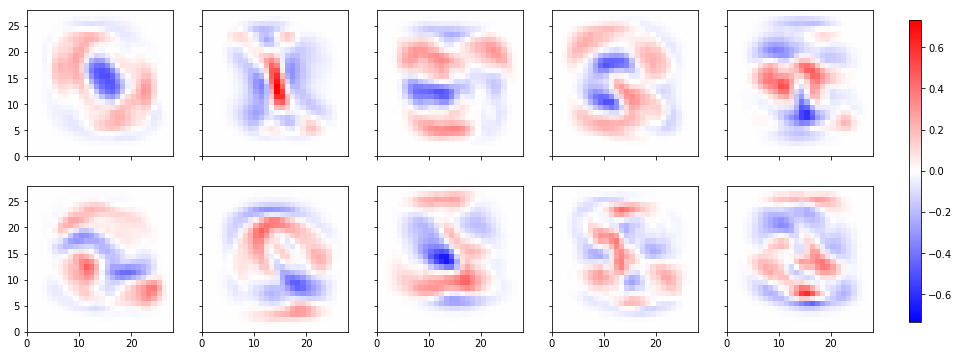

In [7]:
# prep data
We = W.eval()
Wec = [(np.reshape(x, (28, 28))) for x in np.hsplit(We, 10)]
titles = ['Class: {}'.format(n) for n in range(10)]
vmin = min([m.min() for m in Wec])
vmax = max([m.max() for m in Wec])
# ensure the mean is 0, otherwise the base/neutral is non-white
vminmax = max(abs(vmin), vmax)

# create subplots
fig, ax = plt.subplots(2, 5, sharex=True, sharey=True, figsize=(16.9, 5.915))
for index, (image, title) in enumerate(zip(Wec, titles)):
    (row, col) = (math.floor(index / 5), index % 5)
    im = ax[row, col].pcolor(image, cmap='bwr', vmin=-vminmax, vmax=vminmax)
    ax[row, col].set(aspect=1)
    
# adjust for colorbar
fig.subplots_adjust(right=0.82)
cbar_ax = fig.add_axes([0.85, 0.148, 0.01, 0.71])
fig.colorbar(im, cax=cbar_ax, cmap='bwr')

# dump plots
plt.show()

# dump graph itself
tf_show_graph(tf)